## Human In Loop

In [2]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_groq import ChatGroq

In [3]:
## Load LLM model
model = 'qwen/qwen3-32b'
llm = ChatGroq(model=model)

In [1]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
@tool
def multiply(x:int, y:int)->int:
    '''Multiply two numbers'''
    return x*y

In [5]:
multiply.invoke({'x':10,'y':12})

120

In [6]:
@tool
def search(query:str):
    '''Search the web for a query and return the results'''
    tavily_search = TavilySearchResults()
    response = tavily_search.invoke(query)
    return f"Result for {query} is: \n{response}"

In [ ]:
print(search.invoke('Ind vs Eng test match'))

Result for Ind vs Eng test match is: 
[{'title': 'England vs India 1st Test Scorecard - The Indian Express', 'url': 'https://indianexpress.com/section/sports/cricket/live-score/england-vs-india-1st-test-live-score-full-scorecard-highlights-anderson-tendulkar-trophy-2025-enin06202025250825/', 'content': 'to , The much-anticipated five-match Test series between England and India kicks off at Headingley, Leeds, marking the beginning of the ICC World Test Championship 2025-27 cycle for both formidable sides. This series, now rebranded as the Anderson-Tendulkar Trophy, promises a riveting contest between two cricketing powerhouses. All eyes will be on the conditions at Headingley, which traditionally offer assistance to fast bowlers, especially early on. With a mix of sunshine and predicted [...] to , The opening week of the 2025-27 World Test Championship cycle brings with it one of the most high-profile contests on the calendar. India have arrived on English shores for a five-match Test s

In [9]:
## tools
tools = [multiply, search]
## binding tools with llm
llm_with_tools = llm.bind_tools(tools)

In [22]:
res = llm_with_tools.invoke('Ind vs Eng test match')

print(res.content)
print(res.tool_calls)



[{'name': 'search', 'args': {'query': 'Ind vs Eng test match'}, 'id': 'easym970h', 'type': 'tool_call'}]


### Manual Tool Calling

In [ ]:
## Tool Dictionary
tool_mapping = {tool.name:tool for tool in tools}

In [21]:
tool_mapping

{'multiply': StructuredTool(name='multiply', description='Multiply two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000028A4712B6A0>),
 'search': StructuredTool(name='search', description='Search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000028A47308AE0>)}

In [ ]:
res.tool_calls[0]

{'name': 'search',
 'args': {'query': 'Ind vs Eng test match'},
 'id': 'easym970h',
 'type': 'tool_call'}

In [27]:
print(res.tool_calls[0]['name'])
print(res.tool_calls[0]['args'])

search
{'query': 'Ind vs Eng test match'}


In [28]:
tool_mapping[res.tool_calls[0]['name']].invoke(res.tool_calls[0]['args'])

'Result for Ind vs Eng test match is: \n[{\'title\': \'England vs India 1st Test Scorecard - The Indian Express\', \'url\': \'https://indianexpress.com/section/sports/cricket/live-score/england-vs-india-1st-test-live-score-full-scorecard-highlights-anderson-tendulkar-trophy-2025-enin06202025250825/\', \'content\': \'to , The much-anticipated five-match Test series between England and India kicks off at Headingley, Leeds, marking the beginning of the ICC World Test Championship 2025-27 cycle for both formidable sides. This series, now rebranded as the Anderson-Tendulkar Trophy, promises a riveting contest between two cricketing powerhouses. All eyes will be on the conditions at Headingley, which traditionally offer assistance to fast bowlers, especially early on. With a mix of sunshine and predicted [...] to , The opening week of the 2025-27 World Test Championship cycle brings with it one of the most high-profile contests on the calendar. India have arrived on English shores for a five

### Design Human in Loop Workflow

In [30]:
from typing import TypedDict, Annotated, Literal, Sequence
import operator
from langchain_core.messages import BaseMessage, HumanMessage

In [ ]:
class AgentState(TypedDict):
    """State of the agent"""
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [39]:
def invoke_model(state:AgentState):
    
    message = state['messages']
    question = message[-1]
    response = llm_with_tools.invoke(question)
    return {'messages':[response]}

In [40]:
from click import prompt


def invoke_tool(state:AgentState):
    tool_details = state['messages'][-1].tool_calls
    
    if tool_details is None:
        return Exception('No tool call found in the last message')
    
    print(f"Selected tool: {tool_details[0]['name']}")
    
    if tool_details[0]['name']=='search':
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=='no':
            print('Web search discarded by user. Exiting the application')
            raise Exception("Web search is discarded by the user")
        
    response = tool_mapping[tool_details[0]['name']].invoke(tool_details[0]['args'])
    return {'messages':[response]}
    

In [41]:
def router(state:AgentState):
    tool_calls = state['messages'][-1].tool_calls
    if len(tool_calls)>0:
        return 'tools'
    else:
        return 'end'

In [35]:

from langgraph.graph import StateGraph, START,END

#### Earlier we were adding Tool Node so that LLM can decide which tool to call
#### Now we have defined a function invoke tool to call the tools because human will be taking authority to give permission which tool to invoke.

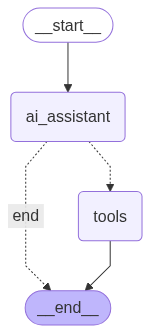

In [42]:
## Build graph
graph = StateGraph(AgentState)
graph.add_node('ai_assistant', invoke_model)
graph.add_node('tools',invoke_tool)

## Logic
graph.add_conditional_edges(
    'ai_assistant',
    router,
    {
        'tools':'tools',
        'end':END
    }
)
graph.add_edge('tools',END)
graph.add_edge(START,'ai_assistant')

## Compile
app = graph.compile()
app

In [43]:
app.invoke({'messages':['What is the current gdp of India']})

Selected tool: search


{'messages': ['What is the current gdp of India',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5w7qrnysh', 'function': {'arguments': '{"query":"current GDP of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 198, 'total_tokens': 323, 'completion_time': 0.20268332, 'prompt_time': 0.007454533, 'queue_time': 0.061300244000000004, 'total_time': 0.210137853}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ab4ff25b-c534-4169-a520-4e0f99d07d37-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of India'}, 'id': '5w7qrnysh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 198, 'output_tokens': 125, 'total_tokens': 323}),
  'Result for current GDP of India is: \n[{\'title\': \'India - GDP, PPP (current International $) - 2025 Data 2026 Forecast ...\', \'url\': \'https://tradingeconomics.com/

In [44]:
app.invoke({'messages':['What is the multiplication of 5 and 20']})

Selected tool: multiply


{'messages': ['What is the multiplication of 5 and 20',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v9cjrdyq5', 'function': {'arguments': '{"x":5,"y":20}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 201, 'total_tokens': 340, 'completion_time': 0.231757628, 'prompt_time': 0.011915603, 'queue_time': 0.061176387, 'total_time': 0.243673231}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d02f6463-9cfe-4f15-9dcf-0f3c36c44b1c-0', tool_calls=[{'name': 'multiply', 'args': {'x': 5, 'y': 20}, 'id': 'v9cjrdyq5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 139, 'total_tokens': 340}),
  100]}

In [46]:
try:
    app.invoke({'messages':['What is the current weather of Kelowna']})
except Exception as e:
    print(f'Exception: {str(e)}')

Selected tool: search
Web search discarded by user. Exiting the application
Exception: Web search is discarded by the user


### LangGraph Inbuilt Human in Loop

In [47]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [55]:
def ai_assistant(state:AgentState):
    print('<-- AI Assistant -->')
    
    response = llm_with_tools.invoke(state['messages'])
    return {'messages':[response]}

In [49]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [50]:
from langgraph.prebuilt import ToolNode, tools_condition

In [52]:
## defining the tool node
tools_node = ToolNode(tools)

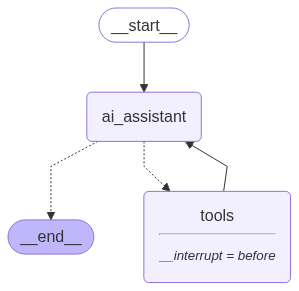

In [56]:
## build graph
builder = StateGraph(AgentState)
builder.add_node('ai_assistant', ai_assistant)
builder.add_node('tools', tools_node)
builder.add_edge(START, 'ai_assistant')
builder.add_conditional_edges(
    'ai_assistant',
    tools_condition
)
builder.add_edge('tools','ai_assistant')

## Compile
## interepting before tools call
app2 = builder.compile(checkpointer=memory, interrupt_before=['tools'])
app2

In [57]:
config = {'configurable':{"thread_id":'1'}}
message = [HumanMessage(content='What is the current update on Ind vs Eng test series')]
response = app2.invoke({'messages':message},config=config)

<-- AI Assistant -->


In [58]:
response

{'messages': [HumanMessage(content='What is the current update on Ind vs Eng test series', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344})]}

In [61]:
snapshot=app2.get_state(config)
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='What is the current update on Ind vs Eng test series', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344})]}, next=('tools',), config={'co

### SnapShot Message

StateSnapshot(
    values={
        'messages': [HumanMessage(content='What is the current update on Ind vs Eng test series', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344})]}, 
    
    next=(
        'tools',), 
    
    config={
        'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f054a4b-4fe0-684c-8001-b9756a33e5dc'}}, 
    
    metadata={
        'source': 'loop', 'writes': {'ai_assistant': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344})]}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-29T04:51:23.640225+00:00', 
    
    parent_config={
        'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f054a4b-4aea-66ab-8000-23752297a9f5'}}, 
    
    tasks=(
        PregelTask(id='bbb9893d-d954-d6ad-737a-a15b313d4309', name='tools', path=('__pregel_pull', 'tools'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [67]:
for i in snapshot:
    print(i)

{'messages': [HumanMessage(content='What is the current update on Ind vs Eng test series', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344})]}
('tools',)
{'configurable': {'thread_id': '1', 'ch

In [62]:
snapshot.next

('tools',)

In [ ]:
snapshot.values['messages'][-1].tool_calls


[{'name': 'search',
  'args': {'query': 'India vs England test series latest updates'},
  'id': 'ttnacnce9',
  'type': 'tool_call'}]

In [74]:
last_message =snapshot.values['messages'][-1]
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344})

In [72]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'India vs England test series latest updates'},
  'id': 'ttnacnce9',
  'type': 'tool_call'}]

In [76]:
tools_detail = last_message.tool_calls
tools_detail

[{'name': 'search',
  'args': {'query': 'India vs England test series latest updates'},
  'id': 'ttnacnce9',
  'type': 'tool_call'}]

In [ ]:
## none means resume the tools call
app2.invoke(None, config=config)

<-- AI Assistant -->


{'messages': [HumanMessage(content='What is the current update on Ind vs Eng test series', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344}),
  ToolMessage(content='Result for India vs Englan

In [83]:
try:
    if tools_detail[0]['name'] =='search':
        user_input = input(prompt= f"[yes/no] do you want to continue with {tools_detail[0]['name']}").lower()
        if user_input=='no':
            print('User denied use of the tool. Exiting the Application')
            raise Exception(f'User denied use of {tools_detail[0]['name']}')
        else:
            response =app2.invoke(None, config=config)
            print(response['messages'][-1].content)
    else:
        response =app2.invoke(None,config=config)
        print(response['messages'][-1].content)
except Exception as e:
    print(f"Exception : {str(e)}")

The India vs England Test series in 2025 is currently underway with the **1st Test** taking place at Headingley from **June 20–24, 2025**. Here's the latest update:

### **1st Test Summary**  
- **India's 1st Innings**: 471 (Shubman Gill 147, Ben Stokes 4/66)  
- **England's 1st Innings**: 465 (Ollie Pope 106, Jasprit Bumrah 5/83)  
- **India's 2nd Innings**: 364 (KL Rahul 137, Josh Tongue 3/72)  
- **England's 2nd Innings**: 373/5 (Ben Duckett 149, Shardul Thakur 2/51)  

The match is still in progress, with England needing 5 wickets to win in their second innings. Live scores and commentary are available on platforms like [ESPNcricinfo](https://www.espncricinfo.com) and [Wisden](https://wisden.com).

### **Upcoming Tests**  
- **2nd Test**: Birmingham, **July 2–6, 2025**  
- **3rd Test**: London, **July 10–14, 2025**  
- **4th Test**: Old Trafford, **July 23–27, 2025**  
- **5th Test**: Edgbaston, **August 3–7, 2025**  

For real-time updates, check [Wikipedia](https://en.wikipedia.o

In [84]:
from langchain_core.messages import AIMessage, ToolMessage

In [85]:
config = {'configurable':{"thread_id":'1'}}
message = [HumanMessage(content='What is the current gdp of India')]
response = app2.invoke({'messages':message},config=config)

<-- AI Assistant -->


In [86]:
response

{'messages': [HumanMessage(content='What is the current update on Ind vs Eng test series', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ttnacnce9', 'function': {'arguments': '{"query":"India vs England test series latest updates"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 201, 'total_tokens': 344, 'completion_time': 0.26506399, 'prompt_time': 0.007604276, 'queue_time': 0.060034654, 'total_time': 0.272668266}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bc76419-d4ba-47e8-8212-a381124dadc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'India vs England test series latest updates'}, 'id': 'ttnacnce9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 143, 'total_tokens': 344}),
  ToolMessage(content='Result for India vs Englan